In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


In [5]:
word2vec = {}

with open(os.path.join('/kaggle/input/globe-6b/glove.6B.100d.txt'), encoding = 'utf8') as f:
    for line in f:
        value = line.split()
        word = value[0]
        vec = np.asarray(value[1:], dtype = 'float32')
        word2vec[word] = vec

print("Found %s word vectors : " %len(word2vec))

Found 400000 word vectors : 


In [6]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
statements = df_train['comment_text'].fillna("DUMMY_VALUE").values
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = df_train[labels].values

In [8]:
MAX_VOCAB_SIZE = 20_000

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(statements)
sequence = tokenizer.texts_to_sequences(statements)

In [9]:
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word

word_index_len = len(word2idx)
word_index_len

210337

In [10]:
num_words = min(MAX_VOCAB_SIZE, word_index_len)
embedding_matrix = np.zeros((num_words, 100))

for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train = pad_sequences(sequence)
train_shape = data_train.shape[1]
print(data_train.shape[1])
print(data_train.shape)

1400
(159571, 1400)


In [12]:
embedding_layer = tf.keras.layers.Embedding(
    num_words,
    100,
    trainable=False,
    input_shape = (train_shape,),
)
embedding_layer.build((None, ))
embedding_layer.set_weights([embedding_matrix])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Input(shape = (train_shape, )))
cnn.add(embedding_layer)
cnn.add(tf.keras.layers.Conv1D(128, 3, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling1D(3))
cnn.add(tf.keras.layers.Conv1D(128, 3, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling1D(3))
cnn.add(tf.keras.layers.Conv1D(128, 3, activation = 'relu'))
cnn.add(tf.keras.layers.GlobalMaxPooling1D())
cnn.add(tf.keras.layers.Dense(128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(len(labels), activation = 'softmax'))
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1400, 100)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1398, 128)      │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 466, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 464, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 154, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 152, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,154,374 (8.22 MB)

 Trainable params: 2,154,374 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
r = cnn.fit(data_train, targets, batch_size = 128, epochs = 10, validation_split = 0.25)

Epoch 1/10
  1/935 ━━━━━━━━━━━━━━━━━━━━ 1:58:34 8s/step - accuracy: 0.2031 - loss: 0.7584

I0000 00:00:1711359069.745952      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


935/935 ━━━━━━━━━━━━━━━━━━━━ 502s 529ms/step - accuracy: 0.9288 - loss: 0.1232 - val_accuracy: 0.9941 - val_loss: 0.0824
Epoch 2/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 604s 647ms/step - accuracy: 0.9941 - loss: 0.0798 - val_accuracy: 0.9894 - val_loss: 0.0829
Epoch 3/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 670s 716ms/step - accuracy: 0.9933 - loss: 0.0749 - val_accuracy: 0.9903 - val_loss: 0.0802
Epoch 4/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 608s 650ms/step - accuracy: 0.9934 - loss: 0.0725 - val_accuracy: 0.9939 - val_loss: 0.0809
Epoch 5/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 491s 526ms/step - accuracy: 0.9930 - loss: 0.0691 - val_accuracy: 0.9931 - val_loss: 0.0790
Epoch 6/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 450s 481ms/step - accuracy: 0.9925 - loss: 0.0668 - val_accuracy: 0.9936 - val_loss: 0.0890
Epoch 7/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 426s 456ms/step - accuracy: 0.9923 - loss: 0.0619 - val_accuracy: 0.9939 - val_loss: 0.0803
Epoch 8/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 410s 439ms/step - accuracy: 0.9916 - loss: 0.05

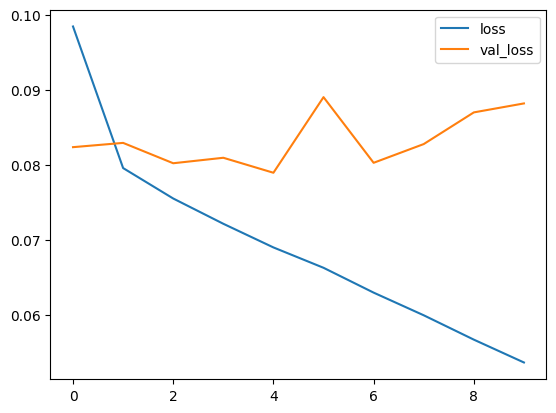

In [16]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

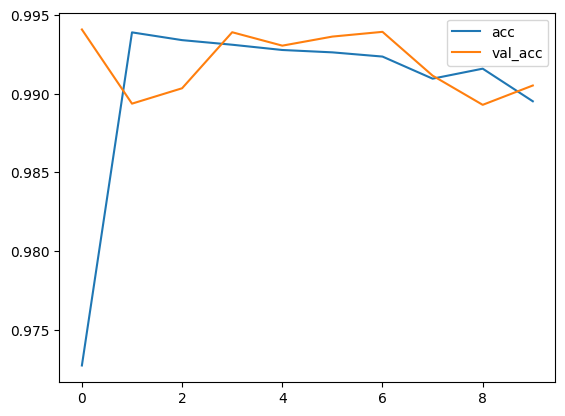

In [17]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score

p = cnn.predict(data_train)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
0.5312438313021393
